## 1. <font color = red> Install and Import the Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.0/999.0 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.1 MB/s eta 0:0

In [ ]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [ ]:
# Define the path of the PDF
single_pdf_path = '/content/drive/MyDrive/Datasets/ayurveda_dataset/Ayurveda Dataset/ayurveda_books/Charaka_Samhita_Text_with_English_Tanslation_-_P.V._Sharma.pdf'
#single_pdf_path = "/content/drive/MyDrive/Datasets/HDFC_Life_Insurance/HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [ ]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    #try:
    tables = single_page.extract_tables()
    #except Exception as e:
    #    print(e)
    # Print the extracted text
    print(text)

In [ ]:
# View the table in the page, if any
if tables: # Check if the tables list is not empty
    display(tables[0])
else:
    print("No tables found on this page.")

No tables found on this page.


#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [28]:
# Define the path where all pdf documents are present
import warnings
warnings.filterwarnings('ignore')
# pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents"
pdf_path = "/content/drive/MyDrive/Datasets/AyurVedapdf"

In [29]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [30]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [31]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing OverviewonAyurvedPrakash.pdf
Finished processing OverviewonAyurvedPrakash.pdf
...Processing The_Paka_Darpanam_The_text_on_Indian_coo.pdf
Finished processing The_Paka_Darpanam_The_text_on_Indian_coo.pdf
...Processing drug_and_conmetic_act_1940.pdf
Finished processing drug_and_conmetic_act_1940.pdf
...Processing heart_diseases.pdf
Finished processing heart_diseases.pdf
...Processing Madhava_Nidana_Madhvakara_Chapters_1-10_Meulenbeld_G.J._Translation.pdf
Finished processing Madhava_Nidana_Madhvakara_Chapters_1-10_Meulenbeld_G.J._Translation.pdf
All PDFs have been processed.


In [76]:
# Concatenate all the DFs in the list 'data' together

ayurveda_pdfs_data = pd.concat(data, ignore_index=True)

In [77]:
ayurveda_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,"[[""See discussions, stats, and author profiles...",OverviewonAyurvedPrakash.pdf
1,Page 2,"J. Res. Educ. Indian Med., 2013; XIX (1-2) 29-...",OverviewonAyurvedPrakash.pdf
2,Page 3,30 Sharma et al. Rasashastra descriptions are ...,OverviewonAyurvedPrakash.pdf
3,Page 4,Ayurveda Prakasha - A Text of Indian Alchemy 3...,OverviewonAyurvedPrakash.pdf
4,Page 5,"32 Sharma et al. Quantity for Grasa, different...",OverviewonAyurvedPrakash.pdf
...,...,...,...
813,Page 725,,Madhava_Nidana_Madhvakara_Chapters_1-10_Meulen...
814,Page 726,,Madhava_Nidana_Madhvakara_Chapters_1-10_Meulen...
815,Page 727,,Madhava_Nidana_Madhvakara_Chapters_1-10_Meulen...
816,Page 728,,Madhava_Nidana_Madhvakara_Chapters_1-10_Meulen...


In [78]:

# Check one of the extracted page texts to ensure that the text has been correctly read

ayurveda_pdfs_data.Page_Text[2]

'30 Sharma et al. Rasashastra descriptions are found in main stream through Chaukhambha Orientalia publications Ayurveda literature. The name of the script Varanasi (Ayurveda Prakasha, 2007). suffixed as Prakasha indicates that this book The pattern of classification of Mineral belongs to the period of Bhava Prakasha, Arka drugs (Rasavarga dravya) is found unique in Prakasha text. Description of Firanga which is nature. included as separate chapter under disease treatment in texts Bhava Prakasha, therefore Subject matter their period may be considered as same (Ayurveda Subject matter of the text is divided into 6 Prakasha, 2007). chapters which contain total 1693 verses. The author compiled the subject matter 1st Chapter : Suta Sadhanadhyaya from various classical texts like Rasa Ratna This chapter is dedicated for Parada samucchaya, Rasa Paddhati, Rasa Ratnakara, (Mercury). Dosha, samskara, drugs (individual Rasa Prakasha Sudhakara, Rasa Hrdaya Tantra, and group with description), use

In [79]:

# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

ayurveda_pdfs_data['Text_Length'] = ayurveda_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [80]:
ayurveda_pdfs_data['Text_Length']

,Text_Length
0,100
1,531
2,520
3,615
4,571
...,...
813,1
814,1
815,1
816,1


In [81]:
# Retain only the rows with a text length of at least 10

ayurveda_pdfs_data = ayurveda_pdfs_data.loc[ayurveda_pdfs_data['Text_Length'] >= 10]
ayurveda_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,"[[""See discussions, stats, and author profiles...",OverviewonAyurvedPrakash.pdf,100
1,Page 2,"J. Res. Educ. Indian Med., 2013; XIX (1-2) 29-...",OverviewonAyurvedPrakash.pdf,531
2,Page 3,30 Sharma et al. Rasashastra descriptions are ...,OverviewonAyurvedPrakash.pdf,520
3,Page 4,Ayurveda Prakasha - A Text of Indian Alchemy 3...,OverviewonAyurvedPrakash.pdf,615
4,Page 5,"32 Sharma et al. Quantity for Grasa, different...",OverviewonAyurvedPrakash.pdf,571
...,...,...,...,...
78,Page 20,"[["""", null], ["""", """"], ["""", null], ["""", """"], [...",heart_diseases.pdf,57
79,Page 21,"[["""", null, null, null], ["""", null, null, """"],...",heart_diseases.pdf,100
80,Page 22,"[["""", null, null, null], ["""", null, """", null],...",heart_diseases.pdf,72
81,Page 23,"[["""", null], ["""", """"], ["""", null], ["""", """"], [...",heart_diseases.pdf,24


In [83]:
# Store the metadata for each page in a separate column

ayurveda_pdfs_data['Metadata'] = ayurveda_pdfs_data.apply(lambda x: {'Book_Specialization_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [84]:
ayurveda_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,"[[""See discussions, stats, and author profiles...",OverviewonAyurvedPrakash.pdf,100,{'Book_Specialization_Name': 'OverviewonAyurve...
1,Page 2,"J. Res. Educ. Indian Med., 2013; XIX (1-2) 29-...",OverviewonAyurvedPrakash.pdf,531,{'Book_Specialization_Name': 'OverviewonAyurve...
2,Page 3,30 Sharma et al. Rasashastra descriptions are ...,OverviewonAyurvedPrakash.pdf,520,{'Book_Specialization_Name': 'OverviewonAyurve...
3,Page 4,Ayurveda Prakasha - A Text of Indian Alchemy 3...,OverviewonAyurvedPrakash.pdf,615,{'Book_Specialization_Name': 'OverviewonAyurve...
4,Page 5,"32 Sharma et al. Quantity for Grasa, different...",OverviewonAyurvedPrakash.pdf,571,{'Book_Specialization_Name': 'OverviewonAyurve...
...,...,...,...,...,...
78,Page 20,"[["""", null], ["""", """"], ["""", null], ["""", """"], [...",heart_diseases.pdf,57,"{'Book_Specialization_Name': 'heart_diseases',..."
79,Page 21,"[["""", null, null, null], ["""", null, null, """"],...",heart_diseases.pdf,100,"{'Book_Specialization_Name': 'heart_diseases',..."
80,Page 22,"[["""", null, null, null], ["""", null, """", null],...",heart_diseases.pdf,72,"{'Book_Specialization_Name': 'heart_diseases',..."
81,Page 23,"[["""", null], ["""", """"], ["""", null], ["""", """"], [...",heart_diseases.pdf,24,"{'Book_Specialization_Name': 'heart_diseases',..."


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [85]:
# Set the API key
filepath = "/content/drive/MyDrive/Colab Notebooks/API_Key/"

with open(filepath + "MamathaK_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [86]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [87]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/ChromaDB_Data'

In [88]:
import chromadb

In [89]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [90]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [95]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

ayurveda_collection = client.get_or_create_collection(name='RAG_on_Ayurveda', embedding_function=embedding_function)

In [96]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = ayurveda_pdfs_data["Page_Text"].tolist()
metadata_list = ayurveda_pdfs_data['Metadata'].tolist()

In [97]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

ayurveda_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [98]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[ 0.02111068, -0.00295514,  0.01295783, ..., -0.02840346,
         -0.00438562, -0.02167932],
        [ 0.03128637,  0.00790349,  0.01120686, ..., -0.01691266,
         -0.00898186, -0.02734145],
        [ 0.03076801,  0.00635668,  0.0079076 , ..., -0.02996125,
         -0.00602285, -0.02493989]]),
 'documents': ['[["See discussions, stats, and author profiles for this publication at: https://www.researchgate.net/publication/264160871\\nOVERVIEW ON AYURVEDA PRAKASHA -A TEXT OF INDIAN ALCHEMY\\nArticle \\u00b7 June 2013\\nDOI: 10.13140/2.1.3974.7205\\nCITATIONS READS\\n5 12,766\\n5 authors, including:\\nRohit Sharma Virupaksha Gupta\\nBanaras Hindu University Sri Chandrasekharendra Saraswathi Viswa Mahavidyalaya University\\n297 PUBLICATIONS 3,515 CITATIONS 21 PUBLICATIONS 114 CITATIONS\\nSEE PROFILE SEE PROFILE\\nPrashant Babanarao Bedarkar Pradeep Kumar Prajapati\\nInstitute of Post Graduate Teaching & Research In Ayurveda Dr. Sarvapalli 

In [99]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [100]:
cache_collection.peek()

{'ids': ['what are the benefits of ashwagandha'],
 'embeddings': array([[-0.01821797, -0.00779137,  0.01683313, ..., -0.03772665,
          0.01243662, -0.02098764]]),
 'documents': ['what are the benefits of ashwagandha'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'included3': 'a',
   'ids2': '7',
   'distances0': '0.4070209264755249',
   'distances4': '0.43537741899490356',
   'metadatas2': "{'Policy_Name': 'OverviewonAyurvedPrakash', 'Page_No.': 'Page 8'}",
   'ids0': '6',
   'ids4': '11',
   'documents4': '[Downloaded free from http://www.ancientscienceoflife.org on Friday, December 19, 2014, IP: 117.236.172.188] || Click here to download free Android application for this journal Book Review pṭola phala (fruit of Trichosantbes dioica), jīvantī śakhā (the herb in the text is indicated for sticky consistency and is rice Caelogyne ovalis), fruit and leaves of kāravallaka (Momordica dominant product, added with certain other fo

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [101]:
# Read the user query

query = input()

What are the benefit of eating Cumin ?


In [105]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [106]:
cache_results

{'ids': [['what are the benefits of ashwagandha']],
 'embeddings': None,
 'documents': [['what are the benefits of ashwagandha']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'included0': 'm',
    'documents1': '32 Sharma et al. Quantity for Grasa, different effects of 3 gunja respectively. The text describes benefits sequential administration of Grasa on Parada, of consumption of Hema, Rajataa, Shulva, importance of Abhraka, Loha, Tamra Jarana Tikshna Jarit Parada in increasing doses for for Dhatuvada, different effects after Jarana of longevity. Features of Rasa Jirna, Rasa Ajirna various Rasavarga dravya, importance of Tikshna and its treatment are mentioned. It is mentioned Loha Jarana for preparation of Swarna, Four that Parada consumed by wrapping in betel leaf types of Swarna Grasa as per quantity of grasa doesn’t causes Vidabandha which is treated with are mentioned for preparation of Shatavedhi Kana and Amruta. Parada an

In [107]:
results = ayurveda_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [108]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(5):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [109]:
results_df

,Metadatas,Documents,Distances,IDs
0,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.459862,10
1,"{'Page_No.': 'Page 4', 'Book_Specialization_Na...",[Downloaded free from http://www.ancientscienc...,0.463842,12
2,{'Book_Specialization_Name': 'OverviewonAyurve...,"32 Sharma et al. Quantity for Grasa, different...",0.479592,4
3,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.486773,11
4,{'Book_Specialization_Name': 'OverviewonAyurve...,Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.508698,3
5,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.514280,9
6,{'Book_Specialization_Name': 'OverviewonAyurve...,Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.520330,7
7,"{'Page_No.': 'Page 7', 'Book_Specialization_Na...",34 Sharma et al. similar properties (in lesser...,0.522650,6
8,"{'Page_No.': 'Page 31', 'Book_Specialization_N...","(3) The Ayurvedic, Siddha and Unani Drugs Cons...",0.536501,43
9,"{'Page_No.': 'Page 6', 'Book_Specialization_Na...",Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.544987,5


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

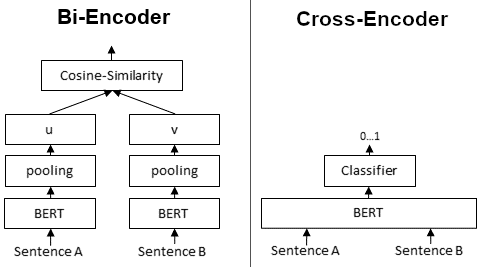

<br>

In [110]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [111]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [130]:
# Test the cross encoder model

scores = cross_encoder.predict([['How to prevent heart diseases?', 'What are the early waring signs of heart diseases?'],
                                ['How to prevent heart diseases?', 'who is president of India?']])

In [131]:
scores

array([ -6.728446, -11.342794], dtype=float32)

In [132]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [133]:
cross_rerank_scores

array([-10.316385, -10.601961,  -8.973675, -10.764913,  -9.819032,
       -10.842757, -10.82534 , -10.642603, -10.759253, -11.014598],
      dtype=float32)

In [134]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [135]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.459862,10,-10.316385
1,"{'Page_No.': 'Page 4', 'Book_Specialization_Na...",[Downloaded free from http://www.ancientscienc...,0.463842,12,-10.601961
2,{'Book_Specialization_Name': 'OverviewonAyurve...,"32 Sharma et al. Quantity for Grasa, different...",0.479592,4,-8.973675
3,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.486773,11,-10.764913
4,{'Book_Specialization_Name': 'OverviewonAyurve...,Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.508698,3,-9.819032
5,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.514280,9,-10.842757
6,{'Book_Specialization_Name': 'OverviewonAyurve...,Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.520330,7,-10.825340
7,"{'Page_No.': 'Page 7', 'Book_Specialization_Na...",34 Sharma et al. similar properties (in lesser...,0.522650,6,-10.642603
8,"{'Page_No.': 'Page 31', 'Book_Specialization_N...","(3) The Ayurvedic, Siddha and Unani Drugs Cons...",0.536501,43,-10.759253
9,"{'Page_No.': 'Page 6', 'Book_Specialization_Na...",Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.544987,5,-11.014598


In [136]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.459862,10,-10.316385
1,"{'Page_No.': 'Page 4', 'Book_Specialization_Na...",[Downloaded free from http://www.ancientscienc...,0.463842,12,-10.601961
2,{'Book_Specialization_Name': 'OverviewonAyurve...,"32 Sharma et al. Quantity for Grasa, different...",0.479592,4,-8.973675


In [137]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
2,{'Book_Specialization_Name': 'OverviewonAyurve...,"32 Sharma et al. Quantity for Grasa, different...",0.479592,4,-8.973675
4,{'Book_Specialization_Name': 'OverviewonAyurve...,Ayurveda Prakasha - A Text of Indian Alchemy 3...,0.508698,3,-9.819032
0,{'Book_Specialization_Name': 'The_Paka_Darpana...,[Downloaded free from http://www.ancientscienc...,0.459862,10,-10.316385


In [138]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [139]:
top_3_RAG

,Documents,Metadatas
2,"32 Sharma et al. Quantity for Grasa, different...",{'Book_Specialization_Name': 'OverviewonAyurve...
4,Ayurveda Prakasha - A Text of Indian Alchemy 3...,{'Book_Specialization_Name': 'OverviewonAyurve...
0,[Downloaded free from http://www.ancientscienc...,{'Book_Specialization_Name': 'The_Paka_Darpana...


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [140]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [141]:
# Generate the response
query = "What are the top three reasons for heart diseases"
response = generate_response(query, top_3_RAG)

In [142]:
# Print the response

print("\n".join(response))

The top three reasons for heart diseases typically include high blood pressure, high cholesterol levels, and smoking. These factors can significantly increase the risk of developing heart diseases.

Citations:
1. Policy Name: Overview on Ayurveda
   Source Page: 32
2. Policy Name: Ayurveda Prakasha - A Text of Indian Alchemy
   Source Page: Not specified
3. Policy Name: The Paka Darpana
   Source Page: Not specified
